# TOI1 pilot image calibration results

These are results of the calibration of our preliminary set of images for the pilot TO1 GNAT task. Participants will be presented images of landmarks from 1. Minneapolis, 2. St Paul, and 3. Non-Minnesota (control) locations. Participants will respond whether the landmark has windows and whether they have personal experience with the landmark. 

This initial set of images contains 75 landmarks from Minneapolis and 12 landmarks from St Paul. 

Images were processed to match the collection of images in terms of their luminance (average pixel intensity) and contrast (SD pixel intensity) with the following steps:

1. Images in .heic (or other non-.jpg) format are converted to .jpg
2. Images are cropped to square
    *Cropping starts from the center of the image
    *After cropping, images are downsampled. The amount of downsampling is set to the minimum resolution of all images in the collection. 
3. Images are converted to CIELab color space, calibrated for luminance (mean pixel intensity) and contrast (standard deviation of pixel intensity), and converted back to RGB images


## Comparing calibration methods

Images were matched for luminance and contrast by pixel intensity histogram matching. Prior to histogram matching, images were also matched for spacial frequency. Two methods of spacial frequency matching were tested

**1. Spectral matching prior to luminance matching**
* This equates the entire Fourier amplitude spectra (for each orientation at each spatial frequency)

**2. Spatial frequency matching prior to luminance matching**
* This equates the rotational average of the Fourier amplitude spectra (i.e., the average energy at each spatial frquency).

Below, histograms show the distribution of average pixel intensity for the two methods, compared to the raw images


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import scipy.io
import fnmatch
import glob

%matplotlib inline

def getStats(path):
    filePath = os.path.join(path, 'lumStats.mat')
    file = scipy.io.loadmat(filePath, squeeze_me = True)
    stats = {'meanLum': float(file['dirStats']['meanLum']), 
             'meanStd': float(file['dirStats']['meanStd']), 
             'method': str(file['dirStats']['type'])
             }
    cs = stats['method'].split('__', 1)[0]
    if cs == 'raw':
        stats['colorspace'] = ''
    else:
        stats['colorspace'] = cs
    return stats

#puts images in a grid
def imgGrid(sourcePaths, num_rows, num_cols):
    # Create a figure and axes for the grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 10))
    # Iterate over the image files in the directory
    for i, path in enumerate(sourcePaths):
        if i >= (num_rows * num_cols):
            break  # Break the loop if grid is filled

        # Load the image
        img = Image.open(path)
        # Calculate the grid position for the current image
        row = i // num_cols
        col = i % num_cols
            
        # Plot the image in the corresponding grid cell
        ax = axes[col]  # Get the current axis
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


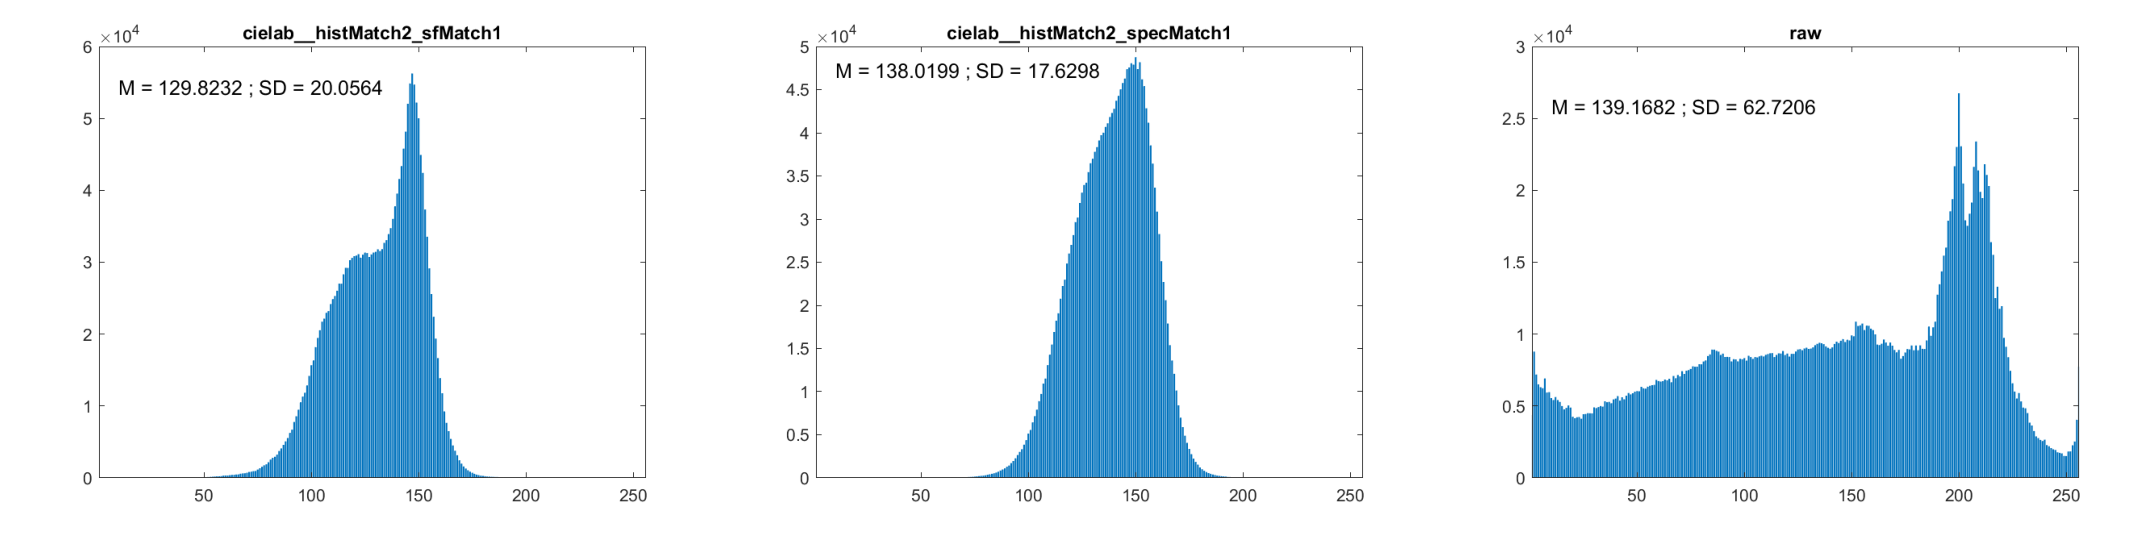

In [7]:

baseDir = os.path.join(os.path.dirname(os.getcwd()), '3_calibImg', 'all') 
sourceFolders = os.listdir(baseDir)
methods = ['cielab__histMatch2_sfMatch1', 'cielab__histMatch2_specMatch1', 'raw']

# Select directories that match any of the substrings
sourceDirs = []
for method in methods:
    sourceDirs.extend(fnmatch.filter(sourceFolders, f'*{method}*'))

sourcePaths = [os.path.join(baseDir, dir, 'DIAGNOSTICS', 'meanLumHist.png') for dir in sourceDirs]

imgGrid(sourcePaths, 1, len(sourcePaths))


Histograms show the average luminance/contrast for each image in the set. 
The histogram on the left shows the luminance/contrast after the spatial-frequency matching method. 
The histogram in the middle shows the luminance/contrast after the spectral matching method
The histogram on the right shows the luminance/contrast of the raw images


Spectral matching performs the best, but the clarity of the images drops when the luminance matching is more aggressive (see below)


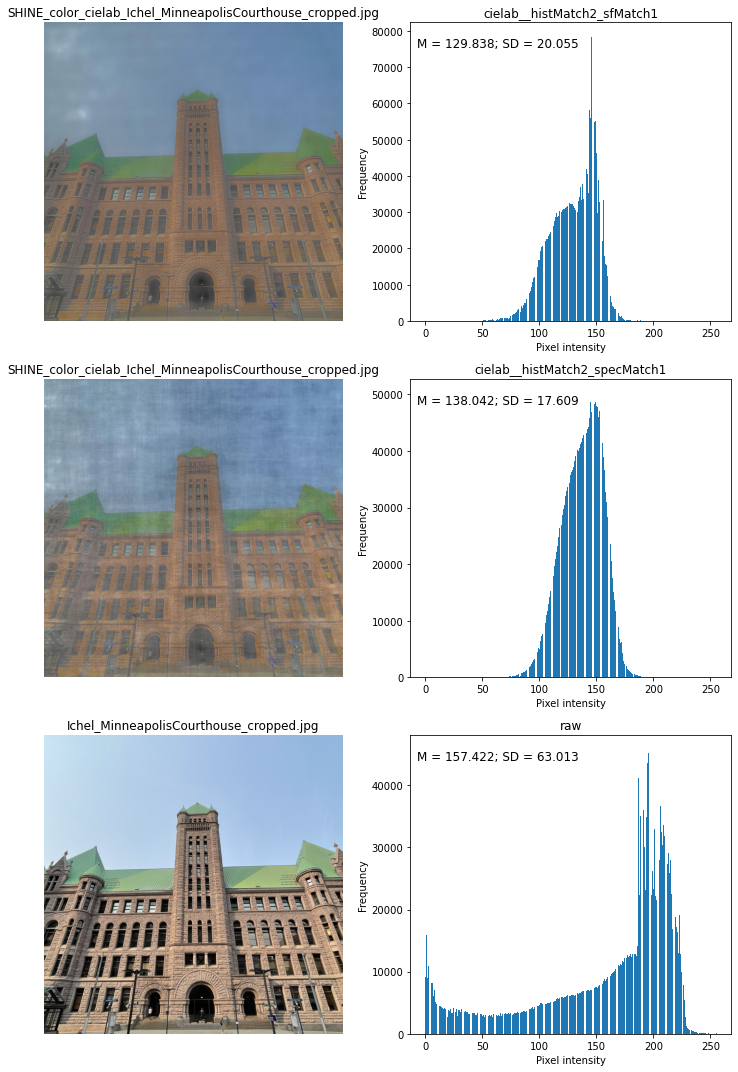

In [8]:
sampleImgInd = 12

# Set up the grid layout
num_plots = len(sourcePaths)
num_rows = int(num_plots)
num_cols = 2

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))

imgPaths = [os.path.join(baseDir, dir) for dir in sourceDirs]
i = 0
for path in imgPaths:
    extension = '.jpg'
    imgs = glob.glob(os.path.join(path, f'*{extension}'))
    imgPath = os.path.join(path, imgs[sampleImgInd])
    imgN = os.path.basename(imgPath)
    img = plt.imread(imgPath)
    axes[i,0].imshow(img)
    axes[i,0].axis('off')
    
    statPath = os.path.join(path, 'DIAGNOSTICS', 'histMat.csv')
    stats = getStats(os.path.join(path, 'DIAGNOSTICS'))
    if stats['method'] != 'raw':
        imgName = imgN.replace('SHINE_color_' + stats['colorspace'] + '_', '')
    else: 
        imgName = imgN
    hist = pd.read_csv(statPath)
    imgHist = hist.loc[:, imgName]
    x = np.arange(len(imgHist))
    bars = axes[i, 1].bar(x, imgHist)
    axes[i, 0].set_title('{}'.format(imgN))
    axes[i, 1].set_title('{}'.format(stats['method']))
    axes[i, 1].set_xlabel('Pixel intensity')
    axes[i, 1].set_ylabel('Frequency')
    freq = imgHist.to_numpy()
    weighted_mean = np.sum(x * freq) / np.sum(freq)
    # Calculate the squared deviations from the mean
    squared_deviations = (x - weighted_mean) ** 2
    # Calculate the weighted variance using the squared deviations and frequencies
    weighted_variance = np.sum(squared_deviations * freq) / np.sum(freq)
    # Calculate the weighted standard deviation using the weighted variance
    weighted_std = np.sqrt(weighted_variance)
    label = 'M = ' + str(round(weighted_mean, 3)) + '; SD = ' + str(round(weighted_std, 3))
    axes[i, 1].text(0.02, 0.95, label, transform=axes[i, 1].transAxes,
                verticalalignment='top', horizontalalignment='left',
                fontsize=12, fontweight='normal', color='black')
    i = i + 1
 # Adjust spacing between subplots
fig.tight_layout()

# Show the grid of images and histograms
plt.show()      




### Comparing average luminance/contrast for Minneapolis vs. St Paul images

There should be no difference between images from Minneapolis and St Paul in terms of their luminance and contrast.
Below histograms show average pixel intensity and contrast for images from the two locations.\
\
There are too few images from St Paul to confirm this at the moment, but they seem to be drawn from similar distributions.


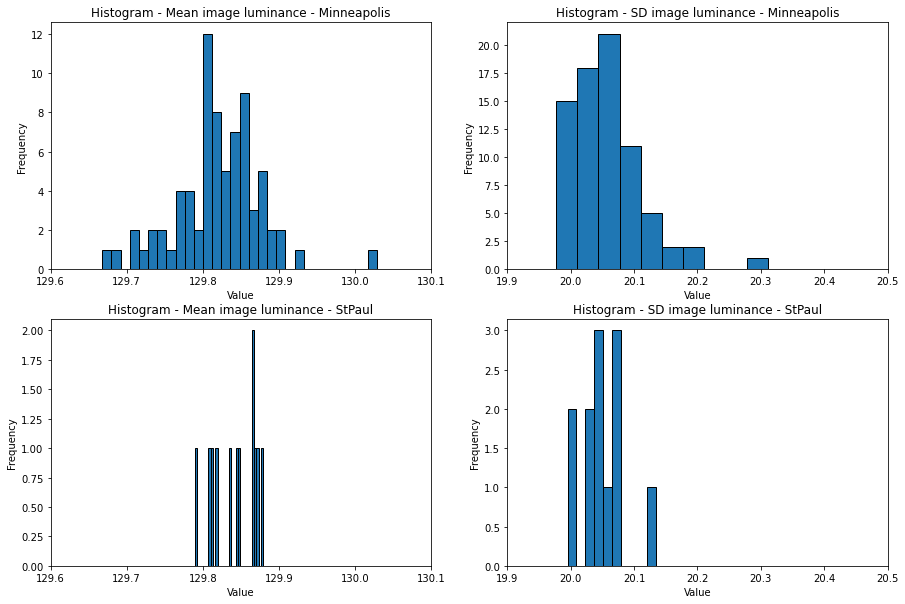

In [9]:
baseDir = os.path.join(os.path.dirname(os.getcwd()), '3_calibImg') 
sourceFolders = os.listdir(baseDir)

dirs = list(filter(lambda item: item != 'all', sourceFolders))
method = 'cielab__histMatch2_sfMatch1'

# Select directories that match any of the substrings
sourceDirs = []
for dir in dirs:
    sourceDirs.extend(fnmatch.filter(sourceFolders, f'*{dir}*'))

sourcePaths = [os.path.join(baseDir, dir, method, 'DIAGNOSTICS', 'meanVec.csv') for dir in sourceDirs]

# Set up the grid layout
num_rows = 2
num_cols = len(sourcePaths)

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
i = 0

for source in sourcePaths:
    for city in dirs:
        if city in source:
            imgCity = city
    if imgCity == 'msp':
        imgCity = 'Minneapolis'
    elif imgCity == 'stp':
        imgCity = 'StPaul'
        
    lum = pd.read_csv(source)
    meanLum = lum['meanLum']
    # Plot histogram for vector1
    axes[i, 0].hist(meanLum, bins=30, edgecolor='black')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].set_title('Histogram - Mean image luminance - ' + imgCity)
    axes[i, 0].set_xlim([129.6, 130.1])  # Set x-axis limits
    
    sdLum = lum['sdLum']
    # Plot histogram for vector1
    axes[i, 1].hist(sdLum, bins=10, edgecolor='black')
    axes[i, 1].set_xlabel('Value')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].set_title('Histogram - SD image luminance - ' + imgCity)
    axes[i, 1].set_xlim([19.9, 20.5])  # Set x-axis limits

    
    
    i = i+1
    

Below, histograms show individual pixel luminance/contrast across the two locations

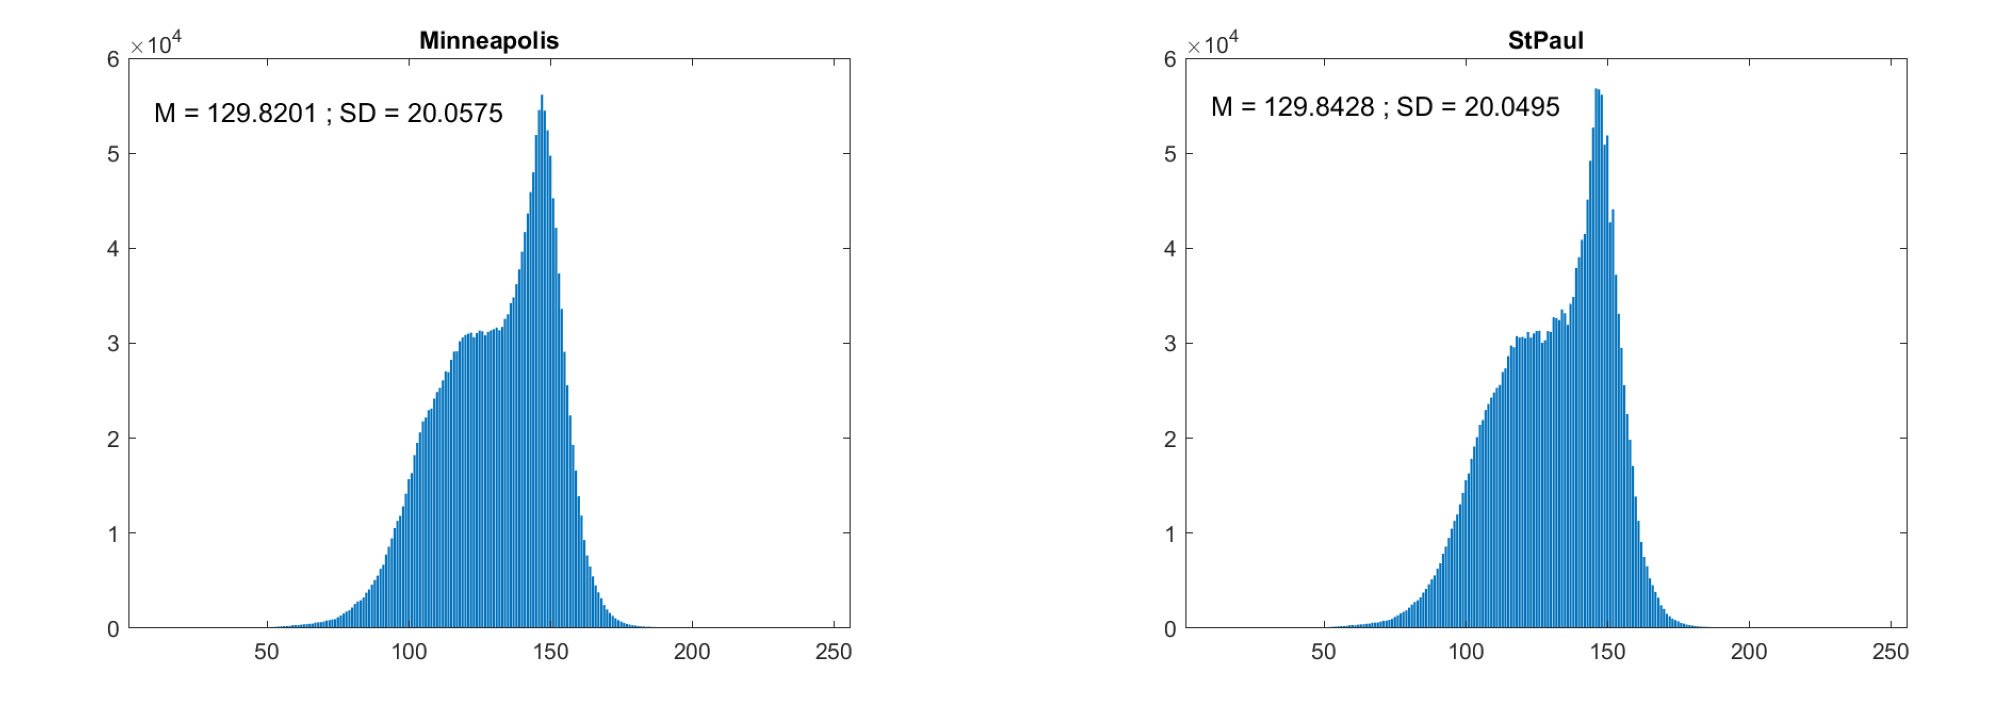

In [10]:
baseDir = os.path.join(os.path.dirname(os.getcwd()), '3_calibImg') 
sourceFolders = os.listdir(baseDir)

dirs = list(filter(lambda item: item != 'all', sourceFolders))
method = 'cielab__histMatch2_sfMatch1'

# Select directories that match any of the substrings
sourceDirs = []
for dir in dirs:
    sourceDirs.extend(fnmatch.filter(sourceFolders, f'*{dir}*'))

sourcePaths = [os.path.join(baseDir, dir, method, 'DIAGNOSTICS', 'meanLumHist.png') for dir in sourceDirs]

imgGrid(sourcePaths, 1, len(sourcePaths))
